**Importing required *libraries***

In [ ]:
import pandas as pd
import numpy as np #
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import datetime
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU


**Loading and preprocessing the data**

In [ ]:
file_path = '/content/traffic.csv' #
traffic_data = pd.read_csv(file_path)

In [ ]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

def classify_period(hour):#
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

traffic_data['Period'] = traffic_data['DateTime'].dt.hour.apply(classify_period)

In [ ]:
junction_2_data = traffic_data[traffic_data['Junction'] == 2]#

junction_2_data['Date'] = junction_2_data['DateTime'].dt.date
grouped_data = junction_2_data.groupby(['Date', 'Period']).agg({'Vehicles': 'sum'}).reset_index()

pivoted_data = grouped_data.pivot(index='Date', columns='Period', values='Vehicles').fillna(0)

<ipython-input-21-196fe3825f91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junction_2_data['Date'] = junction_2_data['DateTime'].dt.date


**Visualization**

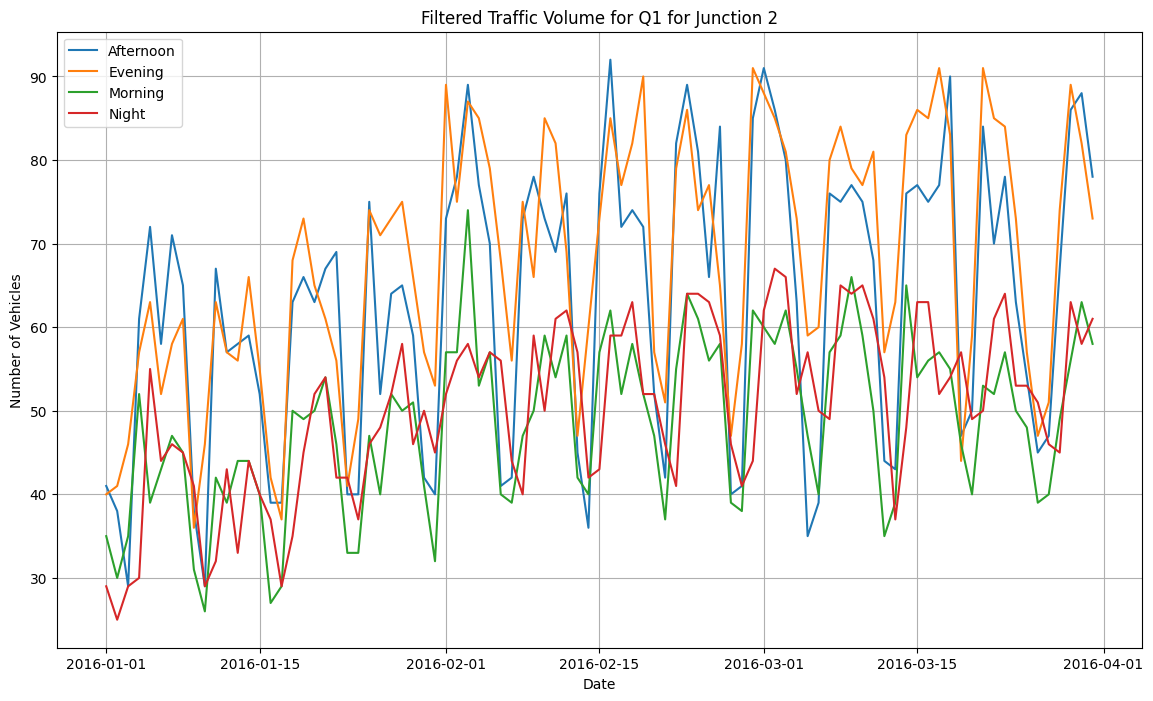

In [ ]:
start_date = datetime.date(2016, 1, 1)#
end_date = datetime.date(2016, 3, 31)

filtered_data = pivoted_data[(pivoted_data.index >= start_date) & (pivoted_data.index <= end_date)]

plt.figure(figsize=(14, 8))
for period in filtered_data.columns:
    plt.plot(filtered_data.index, filtered_data[period], label=period)
plt.title('Filtered Traffic Volume for Q1 for Junction 2')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
evening_data = filtered_data['Evening'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(evening_data)

train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]


In [ ]:
def create_dataset(dataset, look_back=10):#
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))#
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [ ]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, input_shape=(look_back, 1)))#
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')
rnn_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 2s - 863ms/step - loss: 0.3026
Epoch 2/100
2/2 - 0s - 23ms/step - loss: 0.0888
Epoch 3/100
2/2 - 0s - 15ms/step - loss: 0.0678
Epoch 4/100
2/2 - 0s - 15ms/step - loss: 0.1015
Epoch 5/100
2/2 - 0s - 15ms/step - loss: 0.0803
Epoch 6/100
2/2 - 0s - 16ms/step - loss: 0.0497
Epoch 7/100
2/2 - 0s - 17ms/step - loss: 0.0390
Epoch 8/100
2/2 - 0s - 20ms/step - loss: 0.0440
Epoch 9/100
2/2 - 0s - 29ms/step - loss: 0.0493
Epoch 10/100
2/2 - 0s - 17ms/step - loss: 0.0467
Epoch 11/100
2/2 - 0s - 15ms/step - loss: 0.0380
Epoch 12/100
2/2 - 0s - 15ms/step - loss: 0.0312
Epoch 13/100
2/2 - 0s - 15ms/step - loss: 0.0266
Epoch 14/100
2/2 - 0s - 15ms/step - loss: 0.0279
Epoch 15/100
2/2 - 0s - 30ms/step - loss: 0.0287
Epoch 16/100
2/2 - 0s - 15ms/step - loss: 0.0267
Epoch 17/100
2/2 - 0s - 15ms/step - loss: 0.0235
Epoch 18/100
2/2 - 0s - 17ms/step - loss: 0.0211
Epoch 19/100
2/2 - 0s - 15ms/step - loss: 0.0218
Epoch 20/100
2/2 - 0s - 15ms/step - loss: 0.0227
Epoch 21/100
2/2 - 0s - 30ms/step - loss

In [ ]:
train_predict_rnn = rnn_model.predict(X_train)
test_predict_rnn = rnn_model.predict(X_test)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
train_predict_rnn = scaler.inverse_transform(train_predict_rnn)
test_predict_rnn = scaler.inverse_transform(test_predict_rnn)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

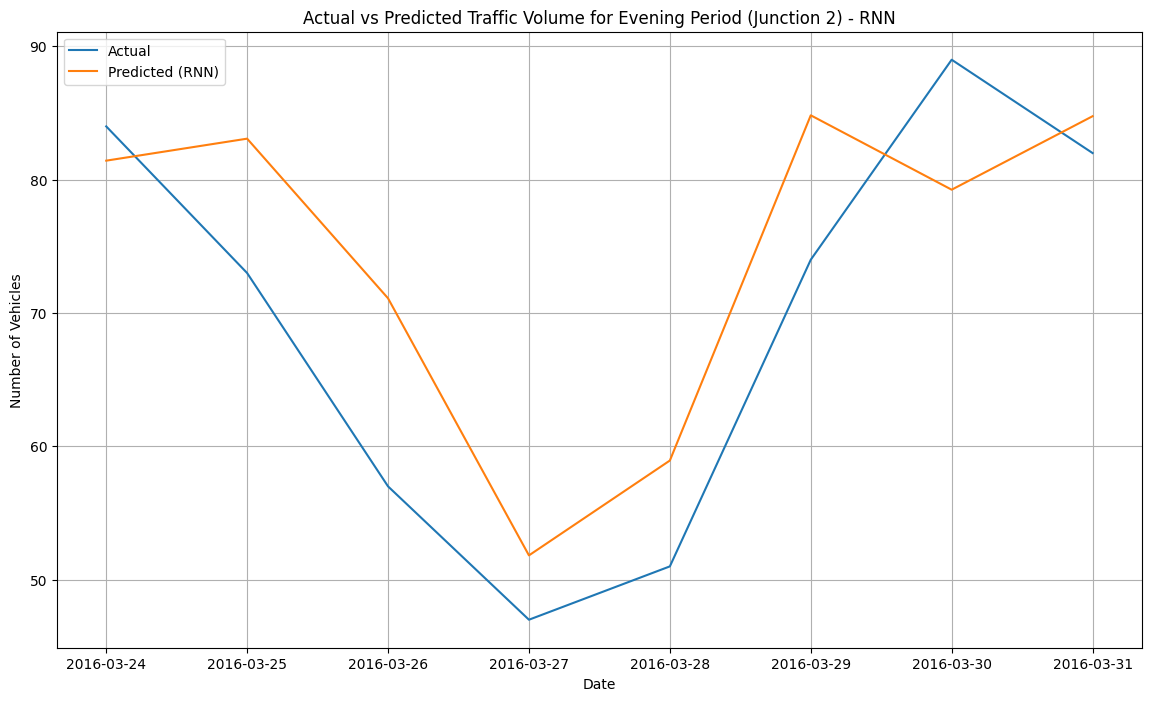

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(filtered_data.index[-len(test_predict_rnn):], Y_test, label='Actual')
plt.plot(filtered_data.index[-len(test_predict_rnn):], test_predict_rnn, label='Predicted (RNN)')
plt.title('Actual vs Predicted Traffic Volume for Evening Period (Junction 2) - RNN')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(look_back, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 2s - 1s/step - loss: 0.1775
Epoch 2/100
2/2 - 0s - 66ms/step - loss: 0.1275
Epoch 3/100
2/2 - 0s - 72ms/step - loss: 0.0890
Epoch 4/100
2/2 - 0s - 64ms/step - loss: 0.0598
Epoch 5/100
2/2 - 0s - 30ms/step - loss: 0.0416
Epoch 6/100
2/2 - 0s - 32ms/step - loss: 0.0382
Epoch 7/100
2/2 - 0s - 33ms/step - loss: 0.0433
Epoch 8/100
2/2 - 0s - 45ms/step - loss: 0.0492
Epoch 9/100
2/2 - 0s - 60ms/step - loss: 0.0500
Epoch 10/100
2/2 - 0s - 28ms/step - loss: 0.0457
Epoch 11/100
2/2 - 0s - 26ms/step - loss: 0.0412
Epoch 12/100
2/2 - 0s - 26ms/step - loss: 0.0373
Epoch 13/100
2/2 - 0s - 28ms/step - loss: 0.0371
Epoch 14/100
2/2 - 0s - 30ms/step - loss: 0.0373
Epoch 15/100
2/2 - 0s - 24ms/step - loss: 0.0387
Epoch 16/100
2/2 - 0s - 21ms/step - loss: 0.0393
Epoch 17/100
2/2 - 0s - 23ms/step - loss: 0.0394
Epoch 18/100
2/2 - 0s - 18ms/step - loss: 0.0387
Epoch 19/100
2/2 - 0s - 30ms/step - loss: 0.0381
Epoch 20/100
2/2 - 0s - 30ms/step - loss: 0.0374
Epoch 21/100
2/2 - 0s - 29ms/step - loss: 0

In [ ]:
train_predict_lstm = lstm_model.predict(X_train)
test_predict_lstm = lstm_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [ ]:
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))


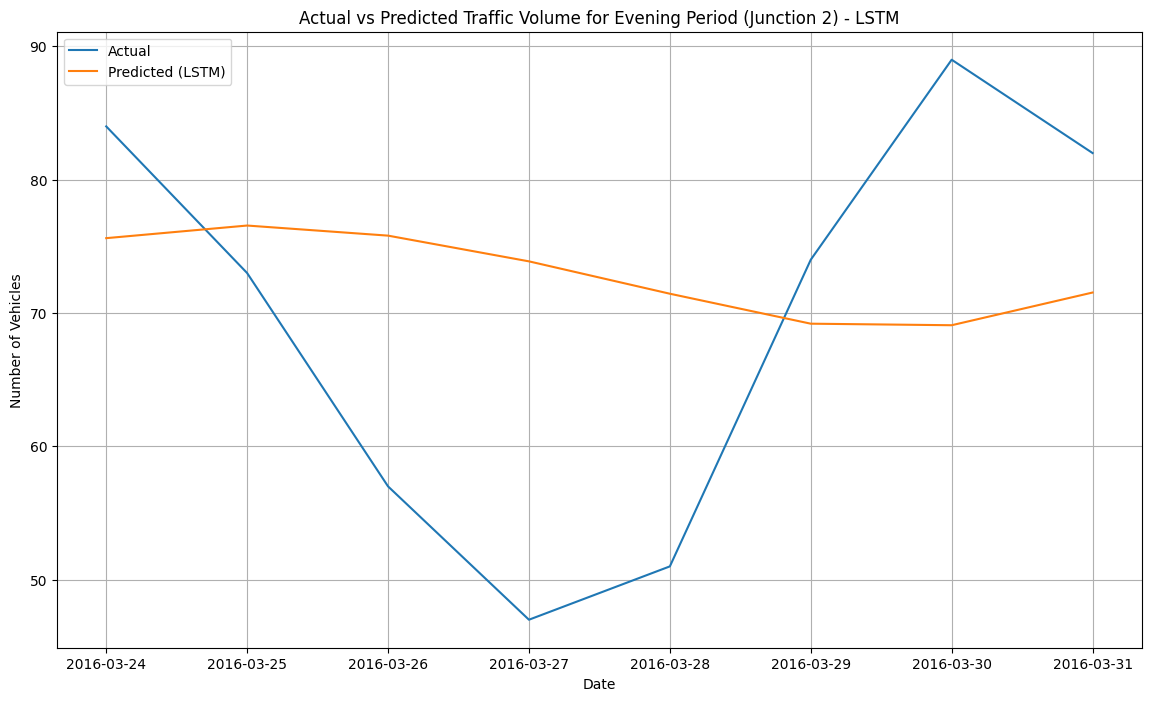

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(filtered_data.index[-len(test_predict_lstm):], Y_test, label='Actual')
plt.plot(filtered_data.index[-len(test_predict_lstm):], test_predict_lstm, label='Predicted (LSTM)')
plt.title('Actual vs Predicted Traffic Volume for Evening Period (Junction 2) - LSTM')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
gru_model = Sequential()
gru_model.add(GRU(50, input_shape=(look_back, 1)))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 2s - 985ms/step - loss: 0.3215
Epoch 2/100
2/2 - 0s - 29ms/step - loss: 0.2551
Epoch 3/100
2/2 - 0s - 19ms/step - loss: 0.1954
Epoch 4/100
2/2 - 0s - 18ms/step - loss: 0.1492
Epoch 5/100
2/2 - 0s - 18ms/step - loss: 0.1104
Epoch 6/100
2/2 - 0s - 30ms/step - loss: 0.0807
Epoch 7/100
2/2 - 0s - 31ms/step - loss: 0.0634
Epoch 8/100
2/2 - 0s - 29ms/step - loss: 0.0543
Epoch 9/100
2/2 - 0s - 18ms/step - loss: 0.0560
Epoch 10/100
2/2 - 0s - 29ms/step - loss: 0.0644
Epoch 11/100
2/2 - 0s - 30ms/step - loss: 0.0685
Epoch 12/100
2/2 - 0s - 19ms/step - loss: 0.0689
Epoch 13/100
2/2 - 0s - 19ms/step - loss: 0.0664
Epoch 14/100
2/2 - 0s - 19ms/step - loss: 0.0606
Epoch 15/100
2/2 - 0s - 19ms/step - loss: 0.0562
Epoch 16/100
2/2 - 0s - 18ms/step - loss: 0.0548
Epoch 17/100
2/2 - 0s - 33ms/step - loss: 0.0543
Epoch 18/100
2/2 - 0s - 28ms/step - loss: 0.0541
Epoch 19/100
2/2 - 0s - 23ms/step - loss: 0.0549
Epoch 20/100
2/2 - 0s - 21ms/step - loss: 0.0553
Epoch 21/100
2/2 - 0s - 18ms/step - loss

In [ ]:
train_predict_gru = gru_model.predict(X_train)
test_predict_gru = gru_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [ ]:
train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

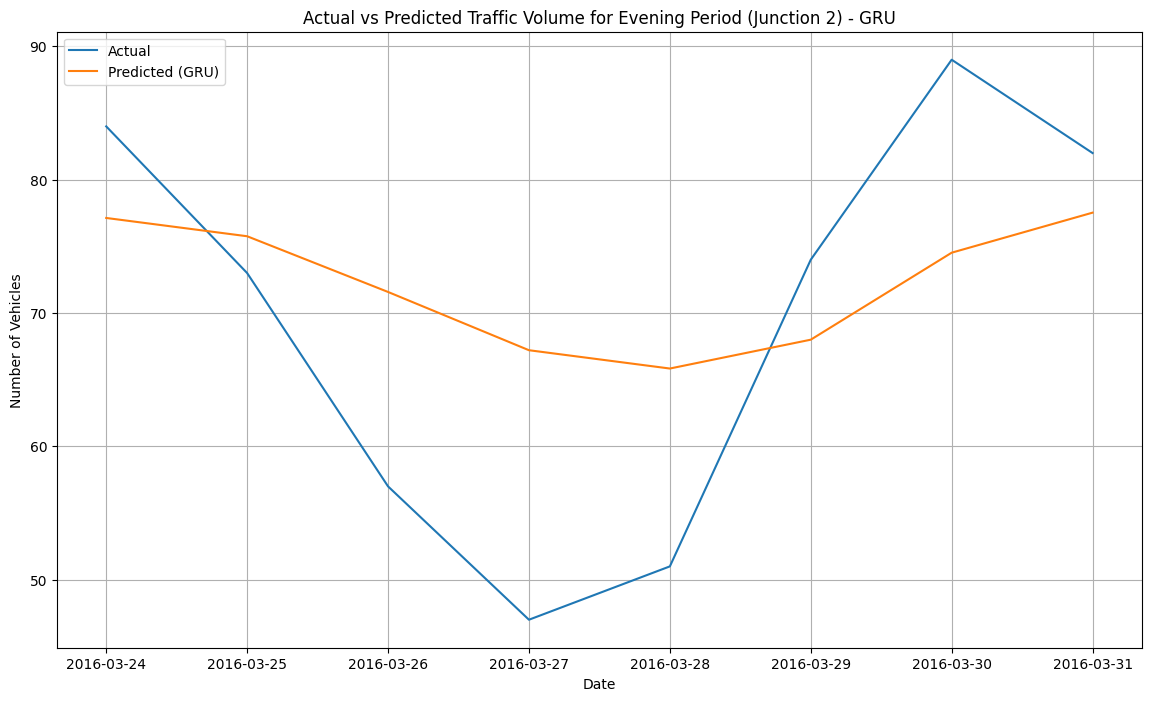

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(filtered_data.index[-len(test_predict_gru):], Y_test, label='Actual')
plt.plot(filtered_data.index[-len(test_predict_gru):], test_predict_gru, label='Predicted (GRU)')
plt.title('Actual vs Predicted Traffic Volume for Evening Period (Junction 2) - GRU')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()

# **morning**

In [92]:
import pandas as pd
import numpy as np #
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import datetime
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU

In [93]:
file_path = '/content/traffic.csv' #
traffic_data = pd.read_csv(file_path)

In [94]:
traffic_data['DateTime'] = pd.to_datetime(traffic_data['DateTime'])

def classify_period(hour):#
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

traffic_data['Period'] = traffic_data['DateTime'].dt.hour.apply(classify_period)

In [95]:
junction_2_data = traffic_data[traffic_data['Junction'] == 2]#

junction_2_data['Date'] = junction_2_data['DateTime'].dt.date
grouped_data = junction_2_data.groupby(['Date', 'Period']).agg({'Vehicles': 'sum'}).reset_index()

pivoted_data = grouped_data.pivot(index='Date', columns='Period', values='Vehicles').fillna(0)


<ipython-input-95-f2143d4f859d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junction_2_data['Date'] = junction_2_data['DateTime'].dt.date


In [96]:
Morning_data = filtered_data['Morning'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Morning_data)

train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[0:train_size], scaled_data[train_size:len(scaled_data)]

In [97]:
def create_dataset(dataset, look_back=10):#
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

In [98]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))#
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [58]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, input_shape=(look_back, 1)))#
rnn_model.add(Dense(1))
rnn_model.compile(loss='mean_squared_error', optimizer='adam')
rnn_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 2s - 962ms/step - loss: 0.0335
Epoch 2/100
2/2 - 0s - 16ms/step - loss: 0.0283
Epoch 3/100
2/2 - 0s - 17ms/step - loss: 0.0240
Epoch 4/100
2/2 - 0s - 16ms/step - loss: 0.0188
Epoch 5/100
2/2 - 0s - 16ms/step - loss: 0.0200
Epoch 6/100
2/2 - 0s - 15ms/step - loss: 0.0167
Epoch 7/100
2/2 - 0s - 15ms/step - loss: 0.0166
Epoch 8/100
2/2 - 0s - 16ms/step - loss: 0.0164
Epoch 9/100
2/2 - 0s - 16ms/step - loss: 0.0153
Epoch 10/100
2/2 - 0s - 16ms/step - loss: 0.0160
Epoch 11/100
2/2 - 0s - 16ms/step - loss: 0.0148
Epoch 12/100
2/2 - 0s - 16ms/step - loss: 0.0151
Epoch 13/100
2/2 - 0s - 15ms/step - loss: 0.0153
Epoch 14/100
2/2 - 0s - 30ms/step - loss: 0.0147
Epoch 15/100
2/2 - 0s - 16ms/step - loss: 0.0147
Epoch 16/100
2/2 - 0s - 29ms/step - loss: 0.0144
Epoch 17/100
2/2 - 0s - 30ms/step - loss: 0.0141
Epoch 18/100
2/2 - 0s - 28ms/step - loss: 0.0142
Epoch 19/100
2/2 - 0s - 15ms/step - loss: 0.0140
Epoch 20/100
2/2 - 0s - 15ms/step - loss: 0.0139
Epoch 21/100
2/2 - 0s - 17ms/step - loss

In [59]:
train_predict_rnn = rnn_model.predict(X_train)
test_predict_rnn = rnn_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [60]:
train_predict_rnn = scaler.inverse_transform(train_predict_rnn)
test_predict_rnn = scaler.inverse_transform(test_predict_rnn)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

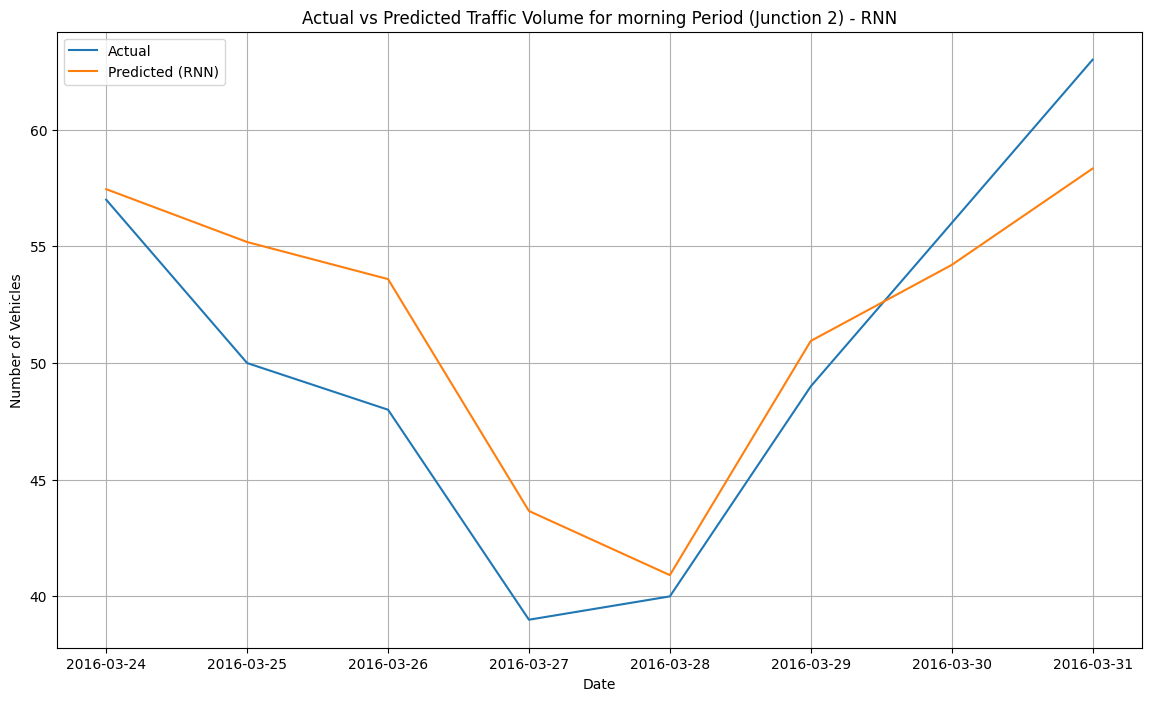

In [62]:
plt.figure(figsize=(14, 8))
plt.plot(filtered_data.index[-len(test_predict_rnn):], Y_test, label='Actual')
plt.plot(filtered_data.index[-len(test_predict_rnn):], test_predict_rnn, label='Predicted (RNN)')
plt.title('Actual vs Predicted Traffic Volume for morning Period (Junction 2) - RNN')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()


In [89]:
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(look_back, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam')
lstm_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 2s - 847ms/step - loss: 0.2034
Epoch 2/100
2/2 - 0s - 18ms/step - loss: 0.1655
Epoch 3/100
2/2 - 0s - 17ms/step - loss: 0.1311
Epoch 4/100
2/2 - 0s - 29ms/step - loss: 0.0998
Epoch 5/100
2/2 - 0s - 17ms/step - loss: 0.0733
Epoch 6/100
2/2 - 0s - 17ms/step - loss: 0.0539
Epoch 7/100
2/2 - 0s - 17ms/step - loss: 0.0400
Epoch 8/100
2/2 - 0s - 30ms/step - loss: 0.0364
Epoch 9/100
2/2 - 0s - 17ms/step - loss: 0.0422
Epoch 10/100
2/2 - 0s - 17ms/step - loss: 0.0463
Epoch 11/100
2/2 - 0s - 31ms/step - loss: 0.0475
Epoch 12/100
2/2 - 0s - 20ms/step - loss: 0.0442
Epoch 13/100
2/2 - 0s - 19ms/step - loss: 0.0403
Epoch 14/100
2/2 - 0s - 30ms/step - loss: 0.0369
Epoch 15/100
2/2 - 0s - 18ms/step - loss: 0.0362
Epoch 16/100
2/2 - 0s - 18ms/step - loss: 0.0363
Epoch 17/100
2/2 - 0s - 18ms/step - loss: 0.0378
Epoch 18/100
2/2 - 0s - 28ms/step - loss: 0.0382
Epoch 19/100
2/2 - 0s - 17ms/step - loss: 0.0384
Epoch 20/100
2/2 - 0s - 19ms/step - loss: 0.0382
Epoch 21/100
2/2 - 0s - 18ms/step - loss

In [90]:
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

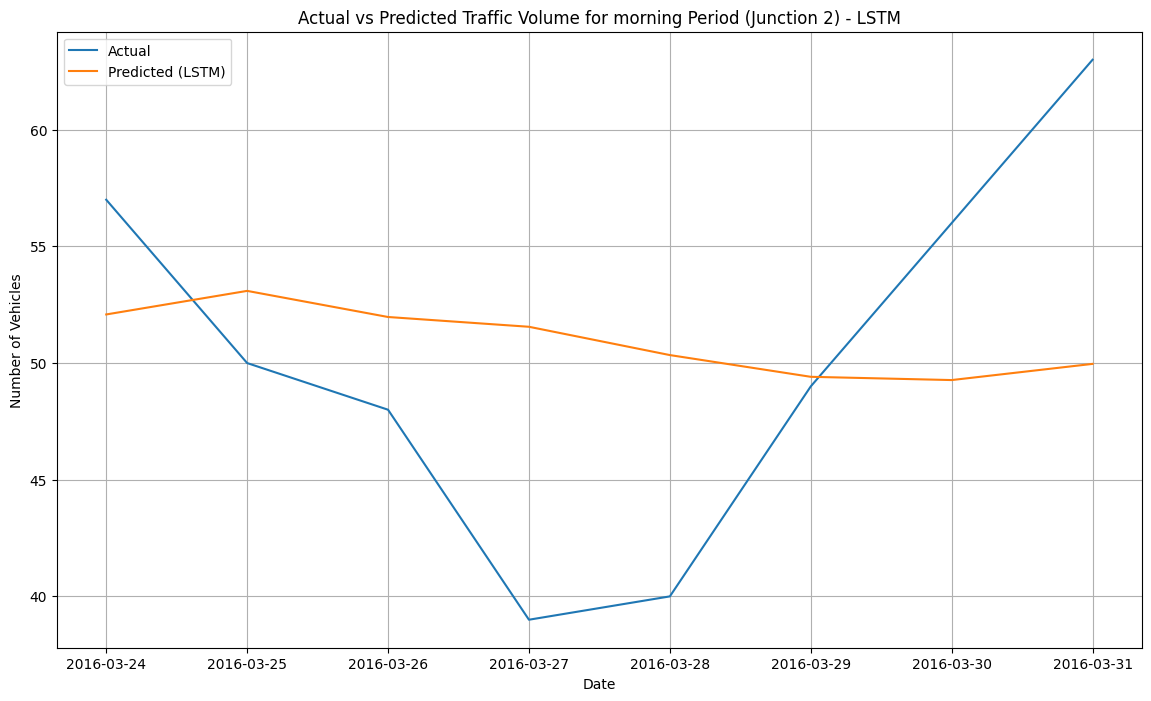

In [91]:
plt.figure(figsize=(14, 8))
plt.plot(filtered_data.index[-len(test_predict_lstm):], Y_test, label='Actual')
plt.plot(filtered_data.index[-len(test_predict_lstm):], test_predict_lstm, label='Predicted (LSTM)')
plt.title('Actual vs Predicted Traffic Volume for morning Period (Junction 2) - LSTM')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()

In [99]:
gru_model = Sequential()
gru_model.add(GRU(50, input_shape=(look_back, 1)))
gru_model.add(Dense(1))
gru_model.compile(loss='mean_squared_error', optimizer='adam')
gru_model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 - 3s - 1s/step - loss: 0.2480
Epoch 2/100
2/2 - 0s - 18ms/step - loss: 0.2004
Epoch 3/100
2/2 - 0s - 18ms/step - loss: 0.1598
Epoch 4/100
2/2 - 0s - 19ms/step - loss: 0.1232
Epoch 5/100
2/2 - 0s - 17ms/step - loss: 0.0950
Epoch 6/100
2/2 - 0s - 17ms/step - loss: 0.0717
Epoch 7/100
2/2 - 0s - 32ms/step - loss: 0.0539
Epoch 8/100
2/2 - 0s - 29ms/step - loss: 0.0451
Epoch 9/100
2/2 - 0s - 18ms/step - loss: 0.0400
Epoch 10/100
2/2 - 0s - 31ms/step - loss: 0.0382
Epoch 11/100
2/2 - 0s - 30ms/step - loss: 0.0423
Epoch 12/100
2/2 - 0s - 36ms/step - loss: 0.0461
Epoch 13/100
2/2 - 0s - 18ms/step - loss: 0.0472
Epoch 14/100
2/2 - 0s - 30ms/step - loss: 0.0462
Epoch 15/100
2/2 - 0s - 30ms/step - loss: 0.0436
Epoch 16/100
2/2 - 0s - 19ms/step - loss: 0.0408
Epoch 17/100
2/2 - 0s - 30ms/step - loss: 0.0392
Epoch 18/100
2/2 - 0s - 21ms/step - loss: 0.0383
Epoch 19/100
2/2 - 0s - 23ms/step - loss: 0.0385
Epoch 20/100
2/2 - 0s - 24ms/step - loss: 0.0383
Epoch 21/100
2/2 - 0s - 23ms/step - loss: 0

In [100]:
train_predict_gru = gru_model.predict(X_train)
test_predict_gru = gru_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [101]:
train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))

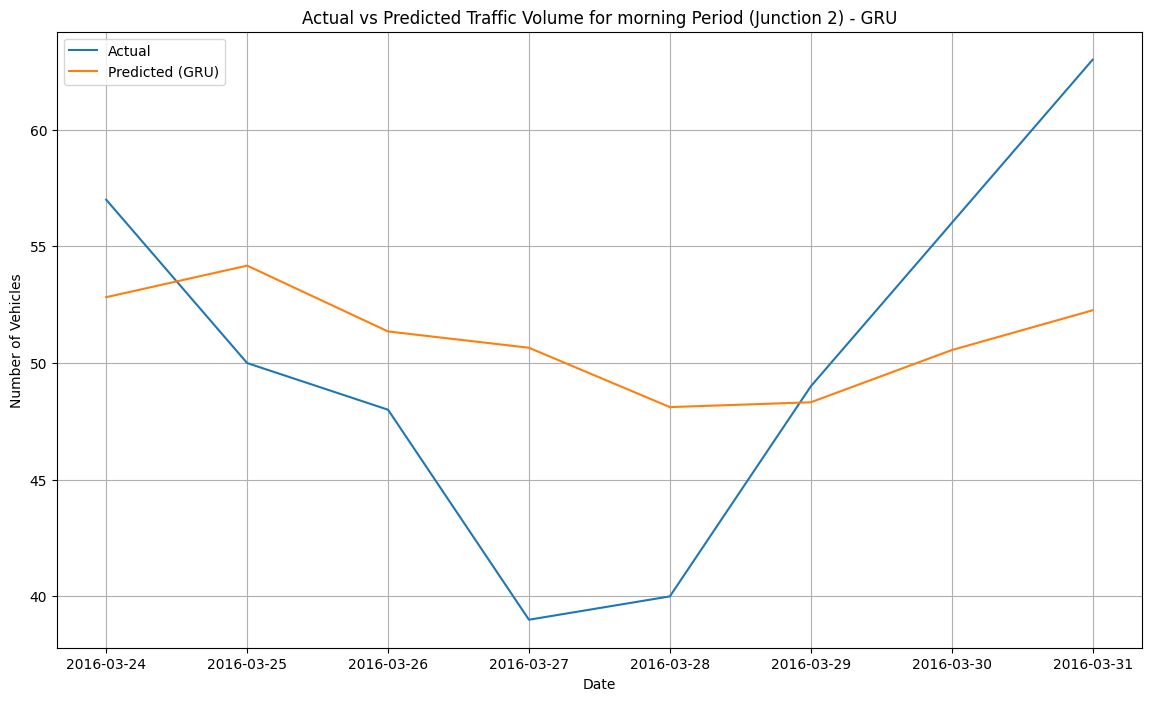

In [102]:
plt.figure(figsize=(14, 8))
plt.plot(filtered_data.index[-len(test_predict_gru):], Y_test, label='Actual')
plt.plot(filtered_data.index[-len(test_predict_gru):], test_predict_gru, label='Predicted (GRU)')
plt.title('Actual vs Predicted Traffic Volume for morning Period (Junction 2) - GRU')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.grid(True)
plt.show()